# Build a transformer based classification model to verify the veracity of claims.

To build this model we will be using PUBHEALTH a comprehensive dataset for explainable automated fact-checking of public health claims. Each instance in the PUBHEALTH dataset has an associated veracity label (true, false, unproven, mixture).


In [1]:
# Checking if the device has GPU 
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [2]:
# performing few computation using to check the system picks GPU to perform it
%tensorflow_version 2.x
import tensorflow as tf
import timeit

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)
  
# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
1.5312350549999962
GPU (s):
0.039204268999981196
GPU speedup over CPU: 39x


#Exploring the data and creating train and test sets

Exploring the data and performing minor manipulation and making to ready to fit and perform different experiments.

Installing the necessary libraries and packeges need to build the model and import the dataset which is available along with huggingfaces default datasets.

Libraries needed
1. pytorch
2. transformers
3. pandas
4. sklearn
5. matplotlib

In [3]:
# Pip install all the packages
!pip3 install transformers numpy torch sklearn datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 3.7 MB/s 
     |████████████████████████████████| 362 kB 85.4 MB/s 
     |████████████████████████████████| 6.6 MB 55.7 MB/s 
     |████████████████████████████████| 596 kB 70.0 MB/s 
     |████████████████████████████████| 101 kB 14.1 MB/s 
     |████████████████████████████████| 212 kB 78.8 MB/s 
     |████████████████████████████████| 1.1 MB 70.3 MB/s 
     |████████████████████████████████| 140 kB 73.3 MB/s 
     |████████████████████████████████| 127 kB 99.8 MB/s 
     |████████████████████████████████| 144 kB 84.9 MB/s 
     |████████████████████████████████| 271 kB 87.2 MB/s 
     |████████████████████████████████| 94 kB 4.5 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
  Attempting uninstall: pyyaml
    Found existing

In [4]:
# Import the libraries
import torch
import pandas as pd
from tqdm.notebook import tqdm
from datasets import list_datasets
datasets_list = list_datasets()
print(datasets_list)

['acronym_identification', 'ade_corpus_v2', 'adversarial_qa', 'aeslc', 'afrikaans_ner_corpus', 'ag_news', 'ai2_arc', 'air_dialogue', 'ajgt_twitter_ar', 'allegro_reviews', 'allocine', 'alt', 'amazon_polarity', 'amazon_reviews_multi', 'amazon_us_reviews', 'ambig_qa', 'americas_nli', 'ami', 'amttl', 'anli', 'app_reviews', 'aqua_rat', 'aquamuse', 'ar_cov19', 'ar_res_reviews', 'ar_sarcasm', 'arabic_billion_words', 'arabic_pos_dialect', 'arabic_speech_corpus', 'arcd', 'arsentd_lev', 'art', 'arxiv_dataset', 'ascent_kb', 'aslg_pc12', 'asnq', 'asset', 'assin', 'assin2', 'atomic', 'autshumato', 'babi_qa', 'banking77', 'bbaw_egyptian', 'bbc_hindi_nli', 'bc2gm_corpus', 'beans', 'best2009', 'bianet', 'bible_para', 'big_patent', 'billsum', 'bing_coronavirus_query_set', 'biomrc', 'biosses', 'blbooks', 'blbooksgenre', 'blended_skill_talk', 'blimp', 'blog_authorship_corpus', 'bn_hate_speech', 'bnl_newspapers', 'bookcorpus', 'bookcorpusopen', 'boolq', 'bprec', 'break_data', 'brwac', 'bsd_ja_en', 'bswac'

In [5]:
# Importing the dataset
from datasets import load_dataset
data = load_dataset('health_fact', split='train')
print(data.description)

Using custom data configuration default


Generating train split:   0%|          | 0/9832 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1235 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1225 [00:00<?, ? examples/s]

Dataset health_fact downloaded and prepared to /root/.cache/huggingface/datasets/health_fact/default/1.1.0/99503637e4255bd805f84d57031c18fe4dd88298f00299d56c94fc59ed68ec19. Subsequent calls will reuse this data.
PUBHEALTH is a comprehensive dataset for explainable automated fact-checking of
public health claims. Each instance in the PUBHEALTH dataset has an associated
veracity label (true, false, unproven, mixture). Furthermore each instance in the
dataset has an explanation text field. The explanation is a justification for which
the claim has been assigned a particular veracity label.

The dataset was created to explore fact-checking of difficult to verify claims i.e.,
those which require expertise from outside of the journalistics domain, in this case
biomedical and public health expertise.

It was also created in response to the lack of fact-checking datasets which provide
gold standard natural language explanations for verdicts/labels.

NOTE: There are missing labels in the datase

In [6]:
# Taking a look at the data
print("Columns {}".format(data.num_columns))
print("Rows {}".format(data.num_rows))
print("Columns names {}".format(data.column_names))

Columns 9
Rows 9832
Columns names ['claim_id', 'claim', 'date_published', 'explanation', 'fact_checkers', 'main_text', 'sources', 'label', 'subjects']


In [7]:
# creating a new column by merging the claim and the explaination columns
data = data.to_pandas()
data['data'] = data['claim'].map(str) + ' ' + data['explanation'].map(str)
data

,claim_id,claim,date_published,explanation,fact_checkers,main_text,sources,label,subjects,data
0,15661,"""The money the Clinton Foundation took from fr...","April 26, 2015","""Gingrich said the Clinton Foundation """"took m...",Katie Sanders,"""Hillary Clinton is in the political crosshair...",https://www.wsj.com/articles/clinton-foundatio...,0,"Foreign Policy, PunditFact, Newt Gingrich,","""The money the Clinton Foundation took from fr..."
1,9893,Annual Mammograms May Have More False-Positives,"October 18, 2011",This article reports on the results of a study...,,While the financial costs of screening mammogr...,,1,"Screening,WebMD,women's health",Annual Mammograms May Have More False-Positive...
2,11358,SBRT Offers Prostate Cancer Patients High Canc...,"September 28, 2016",This news release describes five-year outcomes...,"Mary Chris Jaklevic,Steven J. Atlas, MD, MPH,K...",The news release quotes lead researcher Robert...,https://www.healthnewsreview.org/wp-content/up...,1,"Association/Society news release,Cancer",SBRT Offers Prostate Cancer Patients High Canc...
3,10166,"Study: Vaccine for Breast, Ovarian Cancer Has ...","November 8, 2011","While the story does many things well, the ove...",,"The story does discuss costs, but the framing ...",http://clinicaltrials.gov/ct2/results?term=can...,2,"Cancer,WebMD,women's health","Study: Vaccine for Breast, Ovarian Cancer Has ..."
4,11276,Some appendicitis cases may not require ’emerg...,"September 20, 2010",We really don’t understand why only a handful ...,,"""Although the story didn’t cite the cost of ap...",,2,,Some appendicitis cases may not require ’emerg...
...,...,...,...,...,...,...,...,...,...,...
9827,35948,The Sturgis motorcycle rally in 2020 resulted ...,"September 10, 2020","They want to know if mass-events (protests, co...",Dan Evon,"In September 2020, social media was abuzz over...",,3,"Politics Medical, COVID-19",The Sturgis motorcycle rally in 2020 resulted ...
9828,401,AstraZeneca's infant respiratory drug prioriti...,"September 25, 1995",Britain’s AstraZeneca said a potential medicin...,,The “Breakthrough Therapy” and “Prime” designa...,,2,Health News,AstraZeneca's infant respiratory drug prioriti...
9829,2023,Testicular cancer deaths double with after 40 ...,"February 10, 2011",Men diagnosed with testicular cancer at 40 yea...,,This was true even when initial treatment and ...,http://bit.ly/fGNEw9,2,Health News,Testicular cancer deaths double with after 40 ...
9830,38118,The FDA published “conclusive proof” that the...,"November 22, 2017",FDA Confirms DTaP Vaccine Causes Autism in Nov...,Rich Buhler & Staff,The FDA hasn’t confirmed a link between DTaP v...,https://www.truthorfiction.com/marshall-kamena...,0,Medical,The FDA published “conclusive proof” that the...


In [8]:
# dropping the columns which we will not be using and the missing labels which was labeled as -1
print(data['label'].value_counts())
data = data[['data','label']]
data = data[data['label']!=-1]
data

 2    5078
 0    3001
 1    1434
 3     291
-1      28
Name: label, dtype: int64


,data,label
0,"""The money the Clinton Foundation took from fr...",0
1,Annual Mammograms May Have More False-Positive...,1
2,SBRT Offers Prostate Cancer Patients High Canc...,1
3,"Study: Vaccine for Breast, Ovarian Cancer Has ...",2
4,Some appendicitis cases may not require ’emerg...,2
...,...,...
9827,The Sturgis motorcycle rally in 2020 resulted ...,3
9828,AstraZeneca's infant respiratory drug prioriti...,2
9829,Testicular cancer deaths double with after 40 ...,2
9830,The FDA published “conclusive proof” that the...,0


In [9]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    data.index.values,
    data.label.values,
    test_size=0.2,
    random_state=42,
    stratify=data.label.values
)

data['data_type'] = ['not_set']*data.shape[0]
data.loc[X_train,'data_type'] = 'train'
data.loc[X_val,'data_type'] = 'val'

print("Unique Labels in the labels")
print(data['label'].unique())
data


Unique Labels in the labels
[0 1 2 3]


,data,label,data_type
0,"""The money the Clinton Foundation took from fr...",0,train
1,Annual Mammograms May Have More False-Positive...,1,val
2,SBRT Offers Prostate Cancer Patients High Canc...,1,train
3,"Study: Vaccine for Breast, Ovarian Cancer Has ...",2,train
4,Some appendicitis cases may not require ’emerg...,2,train
...,...,...,...
9827,The Sturgis motorcycle rally in 2020 resulted ...,3,train
9828,AstraZeneca's infant respiratory drug prioriti...,2,train
9829,Testicular cancer deaths double with after 40 ...,2,train
9830,The FDA published “conclusive proof” that the...,0,train


In [10]:
from transformers import BertTokenizer
from torch.utils.data import TensorDataset

tokenizer = BertTokenizer.from_pretrained(
    "bert-base-uncased",
    do_lower_case=True,
    
)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [11]:
encdoded_data_train = tokenizer.batch_encode_plus(
    data[data.data_type=='train'].data.values,
    add_special_tokens=True,
    return_attention_mask=True,
    padding = True,
    truncation=True,
    return_tensors='pt'
)


encdoded_data_val = tokenizer.batch_encode_plus(
    data[data.data_type=='val'].data.values,
    add_special_tokens=True,
    return_attention_mask=True,
    padding = True,
    truncation=True,
    return_tensors='pt'
)

input_ids_train = encdoded_data_train['input_ids']
attention_masks_train = encdoded_data_train['attention_mask']
labels_train = torch.tensor(data[data.data_type=='train'].label.values)

input_ids_val = encdoded_data_val['input_ids']
attention_masks_val = encdoded_data_val['attention_mask']
labels_val = torch.tensor(data[data.data_type=='val'].label.values)

dataset_train = TensorDataset(input_ids_train,attention_masks_train,labels_train)
dataset_val = TensorDataset(input_ids_val,attention_masks_val,labels_val)

# Setting up BERT Pretrained Model

In [12]:
from transformers import BertForSequenceClassification
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels= 4,
    output_attentions=False,
    output_hidden_states=False

)

dataloader_train = DataLoader(
    dataset_train,
    sampler = RandomSampler(dataset_train),
    batch_size = 16
)

dataloader_val = DataLoader(
    dataset_val,
    sampler = RandomSampler(dataset_val),
    batch_size = 16
)

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

# Setting Up Optimizer, Scheduler and defining the Performance Metrics

In [13]:
from transformers import AdamW, get_linear_schedule_with_warmup

optimizer = AdamW(
    model.parameters(),
    lr=1e-4,
    eps=1e-7,
)

epochs = 3
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=len(dataloader_train)*epochs
)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [14]:
import numpy as np
from sklearn.metrics import f1_score

def f1_score_func(preds, labels):
    
    preds_flat = np.argmax(preds,axis=1).flatten()
    labels_flat = labels.flatten()
    
    return f1_score(labels_flat,preds_flat,average='weighted')

# Training the model using the parameters and performance metrics decided

In [15]:
import random

seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model.to(device)

print(device)

cuda


In [16]:
def evaluate(dataloader_val):

    model.eval()
    
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in tqdm(dataloader_val):
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():        
            outputs = model(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals

In [17]:
for epoch in tqdm(range(1, epochs+1)):
    
    model.train()
    
    loss_train_total = 0
    
    progress_bar = tqdm(dataloader_train, 
                        desc='Epoch {:1d}'.format(epoch),
                        leave=False,
                        disable=False)
    
    for batch in progress_bar:
        
        model.zero_grad()
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {
            
            'input_ids' : batch[0],
            'attention_mask' : batch[1],
            'labels' : batch[2]
            
        }
        
        
        outputs = model(**inputs)
        
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(),1.0)
        
        optimizer.step()
        scheduler.step()
        
        progress_bar.set_postfix({'training_loss' : '{:.3f}'.format(loss.item()/len(batch))})
        
    torch.save(model.state_dict(), f'BERT_ft_epoch{epoch}.model')
    
    tqdm.write('\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(dataloader_train) 
    
    tqdm.write(f'Training loss: {loss_train_avg}')
    
    val_loss, predictions, true_vals = evaluate(dataloader_val)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score: {val_f1}')

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/491 [00:00<?, ?it/s]


Epoch {epoch}
Training loss: 0.848652556447536


  0%|          | 0/123 [00:00<?, ?it/s]

Validation loss: 0.7405712409474985
F1 Score: 0.6802117514585384


Epoch 2:   0%|          | 0/491 [00:00<?, ?it/s]


Epoch {epoch}
Training loss: 0.6779549343704935


  0%|          | 0/123 [00:00<?, ?it/s]

Validation loss: 0.6785851822393697
F1 Score: 0.7098911934334802


Epoch 3:   0%|          | 0/491 [00:00<?, ?it/s]


Epoch {epoch}
Training loss: 0.46492122578796935


  0%|          | 0/123 [00:00<?, ?it/s]

Validation loss: 0.6967266960357262
F1 Score: 0.7255588487608763


In [18]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=4,
                                                      output_attentions=False,
                                                      output_hidden_states=False)

model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [19]:
model.load_state_dict(
    torch.load('BERT_ft_epoch3.model',
              map_location = torch.device('cpu'))

)
_, predictions, true_vals = evaluate(dataloader_val)

  0%|          | 0/123 [00:00<?, ?it/s]

# Evaluating the models performance on the validation set

Confusion Matrix


Accuracy: 0.73


Classification Report

              precision    recall  f1-score   support

        True       0.64      0.70      0.67       600
       False       0.46      0.48      0.47       287
    Unproven       0.87      0.84      0.86      1016
     Mixture       0.38      0.16      0.22        58

    accuracy                           0.73      1961
   macro avg       0.59      0.55      0.56      1961
weighted avg       0.73      0.73      0.73      1961





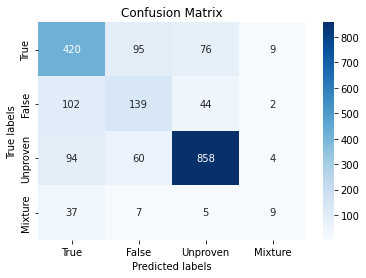

In [20]:
preds = np.argmax(predictions,axis=1).flatten()
labels = true_vals.flatten()
target_names=['True', 'False', 'Unproven','Mixture']

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

confusion = confusion_matrix(labels, preds)
print('Confusion Matrix\n')
ax= plt.subplot()
sns.heatmap(confusion, annot=True, fmt="d",cmap='Blues',ax=ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(target_names); ax.yaxis.set_ticklabels(target_names);

#importing accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(labels, preds)))


from sklearn.metrics import classification_report
print('\nClassification Report\n')
print(classification_report(labels, preds, target_names=target_names))
print('\n')